In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D,GlobalMaxPooling2D, Concatenate
from tensorflow.keras import applications
import tensorflow_hub as hub
import numpy as np
from tensorflow import keras

In [2]:
ROWS=224
COLS=224
train_idg = ImageDataGenerator(vertical_flip=True,
                               horizontal_flip=True,
                               height_shift_range=0.1,
                               width_shift_range=0.1,
                               rescale=1/255)
train_gen = train_idg.flow_from_directory(
    '../input/datatask2/task2/train',
    target_size=(ROWS, COLS),
    batch_size = 32,
    shuffle=True
)
val_datagen = ImageDataGenerator(rescale=1/255)
val_gen = val_datagen.flow_from_directory(
    '../input/datatask2/task2/val',
    target_size=(ROWS, COLS),
    batch_size = 16
)

Found 14465 images belonging to 3 classes.
Found 1808 images belonging to 3 classes.


In [3]:
train_gen.class_indices

{'humanitarian': 0, 'non_informative': 1, 'structure': 2}

In [4]:
class_weights={0:2.0657,1:0.536,2:1.53448}

In [3]:
savemodel = tf.keras.models.load_model('../input/bit-fe-s')

2022-05-29 10:14:45.491219: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-29 10:14:45.593332: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-29 10:14:45.594567: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-29 10:14:45.597040: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
savemodel.summary()

Model: "resnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
root_block (Sequential)      (None, 56, 56, 256)       37632     
_________________________________________________________________
block1 (Sequential)          (None, 56, 56, 1024)      3415552   
_________________________________________________________________
block2 (Sequential)          (None, 28, 28, 2048)      37271552  
_________________________________________________________________
block3 (Sequential)          (None, 14, 14, 4096)      648458240 
_________________________________________________________________
block4 (Sequential)          (None, 7, 7, 8192)        239140864 
_________________________________________________________________
group_norm (GroupNormalizati multiple                  16384     
_________________________________________________________________
re_lu_150 (ReLU)             multiple                  0    

In [5]:
savemodel.trainable=False

In [5]:
module = hub.KerasLayer("https://tfhub.dev/google/bit/s-r101x3/1")

2022-05-29 11:16:59.756740: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-29 11:16:59.860128: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-29 11:16:59.861270: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-29 11:16:59.863164: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [6]:
image=Input((224,224,3))
out=module(image)
out=Dense(512,activation='relu')(out)
out=Dropout(0.3)(out)
o=Dense(3,activation='softmax')(out)
model=Model(inputs=image,outputs=o)

In [7]:
metrics = METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name="precison"),
    tf.keras.metrics.Recall(name="recall")
]
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.003),
              metrics=metrics)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 6144)              381789888 
_________________________________________________________________
dense (Dense)                (None, 512)               3146240   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 384,937,667
Trainable params: 3,147,779
Non-trainable params: 381,789,888
_________________________________________________________________


In [12]:
def lrschedule(epoch,lr):
    lr=0.003
    return lr
from keras.callbacks import LearningRateScheduler
lrate = LearningRateScheduler(lrschedule,verbose=1)


In [8]:
from tensorflow import keras
file_path="weights.best.hdf5"

es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)
mc = keras.callbacks.ModelCheckpoint('best_model_alt-loss-vit', monitor='loss', mode='min', save_best_only=True)
ms = keras.callbacks.ModelCheckpoint('best_model_alt-valloss-vit', monitor='val_loss', mode='min', save_best_only=True)

callbacks_list = [es, mc,ms] #early


history = model.fit(train_gen,
                              validation_data=val_gen, 
                              epochs=100, 
                              shuffle=True, 
                              verbose=True,
                                class_weight=class_weights,
                              callbacks=callbacks_list)

2022-05-29 11:17:49.246566: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-05-29 11:18:22.084774: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


453/453 [==============================] - 607s 1s/step - loss: 0.6919 - accuracy: 0.7081 - precison: 0.7427 - recall: 0.6595 - val_loss: 0.5515 - val_accuracy: 0.7649 - val_precison: 0.7896 - val_recall: 0.7284


2022-05-29 11:28:01.597077: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/100
453/453 [==============================] - 574s 1s/step - loss: 0.5948 - accuracy: 0.7523 - precison: 0.7774 - recall: 0.7185 - val_loss: 0.5164 - val_accuracy: 0.7854 - val_precison: 0.8118 - val_recall: 0.7489
Epoch 3/100
453/453 [==============================] - 583s 1s/step - loss: 0.5725 - accuracy: 0.7681 - precison: 0.7893 - recall: 0.7325 - val_loss: 0.5283 - val_accuracy: 0.7716 - val_precison: 0.8017 - val_recall: 0.7423
Epoch 4/100
453/453 [==============================] - 580s 1s/step - loss: 0.5545 - accuracy: 0.7662 - precison: 0.7886 - recall: 0.7345 - val_loss: 0.4954 - val_accuracy: 0.7942 - val_precison: 0.8179 - val_recall: 0.7600
Epoch 5/100
453/453 [==============================] - 592s 1s/step - loss: 0.5360 - accuracy: 0.7735 - precison: 0.7977 - recall: 0.7430 - val_loss: 0.5126 - val_accuracy: 0.7832 - val_precison: 0.8071 - val_recall: 0.7544
Epoch 6/100
453/453 [==============================] - 574s 1s/step - loss: 0.5297 - accuracy: 0.7810 - 

In [9]:
savemodel = tf.keras.models.load_model('./best_model_alt-valloss-vit')

2022-05-29 15:59:04.595825: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 're_lu_99/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 2 outputs. Output shapes may be inaccurate.
2022-05-29 15:59:04.659040: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'global_average_pooling2d/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 4 outputs. Output shapes may be inaccurate.


In [10]:
def norm(img):
    for i in range(len(img)):
        for j in range(len(img[i])):
            for k in range(len(img[i][j])):
                img[i][j][k]/=255

In [12]:
import os
predicted=[]
real=[]
i=0
for dir in os.listdir("../input/datatask2/task2/test"):
    if dir=='humanitarian':
        r=0
    elif dir =='non_informative':
        r=1
    else:
        r=2
    for path in os.listdir(f'../input/datatask2/task2/test/{dir}'):
        p=f'../input/datatask2/task2/test/{dir}/{path}'
        img = tf.keras.utils.load_img(
    p, target_size=(224, 224)
)
        img_array = tf.keras.utils.img_to_array(img)
        norm(img_array)
        if(i%200==0):
            print(i)
        i+=1
        img_array = tf.expand_dims(img_array, 0) # Create a batch
        

        predictions = savemodel.predict(img_array)
        real.append(r)
        predicted.append(np.argmax(predictions))

0


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


200
400
600
800
1000
1200
1400
1600
1800


In [13]:
from sklearn import metrics
print(metrics.classification_report(real,predicted))
print(metrics.confusion_matrix(real,predicted))

              precision    recall  f1-score   support

           0       0.60      0.72      0.66       284
           1       0.92      0.84      0.88      1131
           2       0.77      0.84      0.80       394

    accuracy                           0.82      1809
   macro avg       0.76      0.80      0.78      1809
weighted avg       0.84      0.82      0.83      1809

[[204  57  23]
 [ 98 955  78]
 [ 36  27 331]]


In [15]:
import shutil
shutil.make_archive('best_model-valloss-BiT', 'zip', './best_model_alt-valloss-vit')

'/kaggle/working/best_model-valloss-BiT.zip'

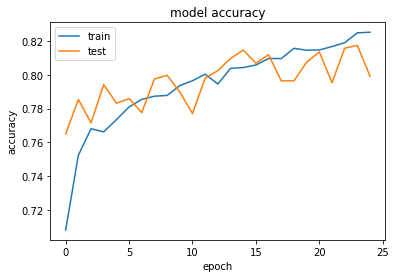

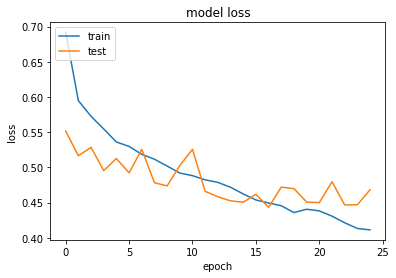

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import seaborn as sebrn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as atlas

In [ ]:
conf_matrix = (confusion_matrix(real, predicted))

# Using Seaborn heatmap to create the plot
fx = sebrn.heatmap(conf_matrix, annot=True)

# labels the title and x, y axis of plot
fx.set_title('Plotting Confusion Matrix using Seaborn\n\n');
fx.set_xlabel('Predicted Values')
fx.set_ylabel('Actual Values ');

# labels the boxes
